In [1]:
experiment=None

In [1]:
#Imports
from comet_ml import Experiment
experiment = Experiment(api_key="YkPEmantOag1R1VOJmXz11hmt", parse_args=False, project_name='SegNet_Recognition_Joint')

COMET INFO: old comet version (1.0.44) detected. current: 2.0.5 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yikeqicn/segnet-recognition-joint/b7a5764a8a2d4ac6b50603f067ade1c2



In [2]:
#from datasets import IRSPRT#RecgArtPrintNoIntsectHVBW
import pytesseract as pyt
from os.path import join, basename, dirname
import tensorflow as tf
import shutil
import os
import sys
import argparse
from glob import glob
import cv2
import numpy as np
import os
import time
from PIL import Image
import editdistance

from torch.utils.data import DataLoader, ConcatDataset, random_split#, SequentialSampler #yike: add SequentialSampler
import torch
import torchvision
import torchvision.transforms as transforms
#from datasets import IRS #ArtPrintNoIntsectLBW,ArtPrintNoIntsectLBW_biameyd_siameyd,ArtPrintNoIntsectLBW_bpr_spr,ArtPrintNoIntsectLBW_biameyd_sprt
############from Model_Unet_github import *
from utils_seg import *
import utils_recg


from Model_Binary_Joint import *
############from recognition.Model import RecgModel, DecoderType
#from recognition.utils import log_image

home = os.environ['HOME']

# Segment Parameters

In [3]:
#General Settings
parser = argparse.ArgumentParser()

# system basics
#parser.add_argument("-name", default='segnet_unet_hvbw_all_combine_100_epoches', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github
parser.add_argument("-name_seg", default='new_segnet_joint', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github
#segnet_binary_100epoch_unet_github
parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")

parser.add_argument("-train", default=False, help="train the NN", action="store_true")
parser.add_argument("-validate", help="validate the NN", action="store_true")

parser.add_argument("-transfer",default=False, help="test the NN", action="store_true")

parser.add_argument("-test",default=True, help="test the NN", action="store_true")

# image and logistic parameters 
parser.add_argument("-image_h", default=32, type=int, help='image height') #('image_h', "360", """ image height """) 32
parser.add_argument("-image_w", default=128, type=int, help='image width')#('image_w', "480", """ image width """)128
#parser.add_argument("-image_h", default=360, type=int, help='image height') 
#parser.add_argument("-image_w", default=480, type=int, help='image width')

parser.add_argument("-image_c", default=1, type=int, help='image channel')#('image_c', "3", """ image channel (RGB) """)
parser.add_argument("-num_class", default=2, type=int, help='total class number')

# training hyperparam
parser.add_argument("-batch_size_seg", default=10, type=int, help='batch_size')
parser.add_argument("-lrInit", default=1e-3, type=int, help='initial lr')
parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time') # not sure
parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time') # not sure
parser.add_argument('-max_epoch',default=100, type=int,help='max epoch numbers')



# file paths
parser.add_argument('-ckpt_root', default="/root/ckpt", type=str,help= "dir to store ckpt") # log_dir !!!!!
parser.add_argument('-data_root', default="/root/datasets", type=str, help=" root to any data folder ")
parser.add_argument('-urlTranferFrom', default="", type=str, help=" archived model url ")


#args = parser.parse_args()



_StoreAction(option_strings=['-urlTranferFrom'], dest='urlTranferFrom', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=' archived model url ', metavar=None)

# Recognition Parameters

In [4]:
# Recognition Model
# basic operations
parser.add_argument("-name_recg", default="recg_new_five_datasets", type=str, help="name of the log") #'dense_128_32_noartifact_beamsearch_5_datasets'
#parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")
#parser.add_argument("-train", help="train the NN", action="store_true")
#parser.add_argument("-validate", help="validate the NN", action="store_true")
#parser.add_argument("-transfer", action="store_true")
#actually not effective:
parser.add_argument("-batchesTrained", default=0, type=int, help='number of batches already trained (for lr schedule)') 
# beam search
parser.add_argument("-beamsearch", help="use beam search instead of best path decoding",default=True, action="store_true")
parser.add_argument("-wordbeamsearch", help="use word beam search instead of best path decoding", action="store_true")
# training hyperparam
parser.add_argument("-batchsize_recg", default=10, type=int, help='batch size') # actually not effective in infrerence
#parser.add_argument("-lrInit", default=1e-2, type=float, help='initial learning rate') # actually not effective
parser.add_argument("-optimizer", default='rmsprop', help="adam, rmsprop, momentum") # actually not effective
parser.add_argument("-wdec", default=1e-4, type=float, help='weight decay') # acctually not effective
#parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time')
#parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time')
parser.add_argument("-epochEnd", default=40, type=int, help='end after this many epochs')
# trainset hyperparam
#parser.add_argument("-noncustom", help="noncustom (original) augmentation technique", action="store_true")
#parser.add_argument("-noartifact", help="dont insert artifcats", action="store_true")
#parser.add_argument("-iam", help='use iam dataset', action='store_true')
# densenet hyperparam
parser.add_argument("-nondensenet", help="use noncustom (original) vanilla cnn", action="store_true")
parser.add_argument("-growth_rate", default=12, type=int, help='growth rate (k)')
parser.add_argument("-layers_per_block", default=18, type=int, help='number of layers per block')
parser.add_argument("-total_blocks", default=5, type=int, help='nuber of densenet blocks')
parser.add_argument("-keep_prob", default=1, type=float, help='keep probability in dropout')
parser.add_argument("-reduction", default=0.4, type=float, help='reduction factor in 1x1 conv in transition layers')
parser.add_argument("-bc_mode", default=True, type=bool, help="bottleneck and compresssion mode")
# rnn,  hyperparams
parser.add_argument("-rnndim", default=256, type=int, help='rnn dimenstionality') #256
parser.add_argument("-rnnsteps", default=32, type=int, help='number of desired time steps (image slices) to feed rnn')
# img size
parser.add_argument("-imgsize", default=[128,32], type=int, nargs='+') #qyk default 128,32 // use segnet definition
# testset crop
#parser.add_argument("-crop_r1", default=3, type=int)
#parser.add_argument("-crop_r2", default=28, type=int)
#parser.add_argument("-crop_c1", default=10, type=int)
#parser.add_argument("-crop_c2", default=115, type=int)
# filepaths
parser.add_argument("-dataroot", default='/root/datasets', type=str)
#######parser.add_argument("-ckptroot", default='/root/ckpt', type=str)##############
#parser.add_argument("-urlTransferFrom", default=None, type=str)

args = parser.parse_known_args()[0]

### SegNet
home = os.environ['HOME']
#name = args.name
#ckptroot = join(home, 'ckpt')
#args.ckptpath = join(ckptroot, name)
#os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

####args = parser.parse_known_args()[0]

name_seg = args.name_seg
name_recg=args.name_recg

os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

ckptroot = args.ckpt_root
args.ckptpath_seg = join(ckptroot, name_seg)
args.ckptpath_recg = join(ckptroot, name_recg)
if args.name_seg=='debug_seg_': shutil.rmtree(args.ckptpath_seg, ignore_errors=True)
if args.name_recg=='debug_recg_': shutil.rmtree(args.ckptpath_recg, ignore_errors=True)

os.makedirs(args.ckptpath_seg, exist_ok=True)
os.makedirs(args.ckptpath_recg, exist_ok=True)

#recg_name=args.recg_name
#args.regckptpath=join(ckptroot,recg_name)

# Dataset

In [5]:
experiment.set_name('JointRecognitionTest_sameD_psm7_dilate')
experiment.log_parameters(vars(args))

In [6]:
from datasets_seg import *

In [7]:
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: cv2.resize(img, (args.image_w,args.image_h), interpolation=cv2.INTER_CUBIC)),
    transforms.Lambda(lambda img: np.expand_dims(img,3) ),
    #transforms.Lambda(lambda img: add_artifacts(img,args)),
    #transforms.Lambda(lambda img: cv2.transpose(img))
    ])
testset=ArtPrintNoIntsectBinary(transform=transform_train)
testloader = DataLoader(testset, batch_size=args.batch_size_seg*5, shuffle=False, drop_last=False,num_workers=2)

/root/datasets/artifact_images_no_intersect already exists, skipping download


In [8]:
len(testset)

284246

# Testing

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0.0
0.00035180794100884446
0.0007036158820176889
0.0010554238230265334
0.0014072317640353778
0.0017590397050442222
0.002110847646053067
0.002462655587061911
0.0028144635280707556
0.0031662714690796003
0.0035180794100884445
0.003869887351097289
0.004221695292106134
0.0045735032331149774
0.004925311174123822
0.005277119115132667
0.005628927056141511
0.005980734997150356
0.0063325429381592005
0.006684350879168044
0.007036158820176889
0.0073879667611857335
0.007739774702194578
0.008091582643203423
0.008443390584212267
0.008795198525221112
0.009147006466229955
0.0094988144072388
0.009850622348247644
0.010202430289256489
0.010554238230265333
0.010906046171274178
0.011257854112283023
0.011609662053291867
0.011961469994300712
0.012313277935309556
0.012665085876318401
0.013016893817327244
0.013368701758336089
0.013720509699344933
0.014072317640353778
0.014424125581362622
0.014775933522371467
0.015127741463380312
0.015479549404389156
0.015831357345398
0.016183165286406846
0.01653497322741569
0.0

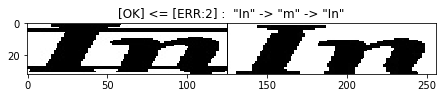

In [11]:
  upload=True
  numCharErr, numCharTotal, numWordOK, numWordTotal = 0, 0, 0, 0
  numCharErrClean, numWordOKClean = 0, 0
  kernel = np.ones((2,2), np.uint8)
  #plt.figure(figsize=(6,2))
  counter = 0
  lenidx=len(testset)
  for idx, (images,_ ,labels) in enumerate(testloader):
    
    if np.mod(idx,100)==0:
      print(str(idx/lenidx))
    images=images.numpy()
    
    #cleaneds,clean_recgs=model_joint.inferCleanBatchJoint(images);
    cleaneds=model_joint.imageCleanSeg(images);
    images=np.squeeze(images,3)
    #org_recgs=model_recg.inferBatchRecg(np.transpose(images,axes=(2,3)));
    
    #cleaned_list=model.imageClean2(images)

    for img,img_cl,label in zip(images,cleaneds,labels):
        #img=np.squeeze(img,3)
        #img_cl= np.squeeze(img_cl).astype(np.dtype('uint8'))
        img_pil=Image.fromarray(img)
        
        img_cl=cv2.dilate(img_cl, kernel, iterations=1)
        img_cl=cv2.erode(img_cl, kernel, iterations=1)
        img_cl_pil=Image.fromarray(img_cl)
        
        rec=pyt.image_to_string(img_pil,config='-psm 7')
        rec_cl=pyt.image_to_string(img_cl_pil,config='-psm 7')
        
        
        numWordOK += 1 if label == rec else 0 #batch.gtTexts[i]
        numWordTotal += 1
        dist0 = editdistance.eval(rec, label)# batch.gtTexts[i])
        numCharErr += dist0
        numCharTotal += len(label)#len(labels)
        
        numWordOKClean += 1 if label == rec_cl else 0 #batch.gtTexts[i]
        #numWordTotal += 1
        dist1 = editdistance.eval(rec_cl, label)# batch.gtTexts[i])
        numCharErrClean+= dist1
        #numCharTotal += len(labels)
        
        if upload and counter<2000: # log images
            im_save=np.concatenate((img,img_cl),axis=1)
            text = ' '.join(['[OK]' if dist1 == 0 else '[ERR:%d]' % dist1,'<=','[OK]' if dist0 == 0 else '[ERR:%d]' % dist0,': ' ,'"' + label + '"', '->', '"' + rec + '"', '->', '"' + rec_cl + '"'])
            log_image2(experiment, im_save, text, 'test_remove_artifacts', args.ckptpath_seg, counter)
        
        
        counter+=1
        

  charErrorRate = numCharErr / numCharTotal
  wordAccuracy = numWordOK / numWordTotal
  charErrorRateClean = numCharErrClean / numCharTotal
  wordAccuracyClean = numWordOKClean / numWordTotal
  print('VALID: Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate * 100.0, wordAccuracy * 100.0))
  print('VALID: Cleaned Character error rate: %f%%. Cleaned Word accuracy: %f%%.' % (charErrorRateClean * 100.0, wordAccuracyClean * 100.0))
  experiment.log_metric('valid/raw/cer', charErrorRate)#, step)
  experiment.log_metric('valid/raw/wer', 1-wordAccuracy)#, step)
  experiment.log_metric('valid/clean/cer', charErrorRateClean)#, step)
  experiment.log_metric('valid/clean/wer', 1-wordAccuracyClean)#, step)

In [7]:
  charErrorRate = numCharErr / numCharTotal
  wordAccuracy = numWordOK / numWordTotal
  charErrorRateClean = numCharErrClean / numCharTotal
  wordAccuracyClean = numWordOKClean / numWordTotal
  print('VALID: Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate * 100.0, wordAccuracy * 100.0))
  print('VALID: Cleaned Character error rate: %f%%. Cleaned Word accuracy: %f%%.' % (charErrorRateClean * 100.0, wordAccuracyClean * 100.0))
  experiment.log_metric('valid/raw/cer', charErrorRate)#, step)
  experiment.log_metric('valid/raw/wer', 1-wordAccuracy)#, step)
  experiment.log_metric('valid/clean/cer', charErrorRateClean)#, step)
  experiment.log_metric('valid/clean/wer', 1-wordAccuracyClean)#, step)

VALID: Character error rate: 34.987826%. Word accuracy: 6.112309%.
VALID: Cleaned Character error rate: 6.821115%. Cleaned Word accuracy: 66.673094%.


# Model Initiate

In [9]:
model_recg = Model(args, charList=open(join(args.ckptpath_recg, 'charList.txt')).read(), loss_beta=0.6,loss_weight=[.5,.5], decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=True,mustRestore_recg=True, joint=False)

GGG
[None, 32, 128, 1]
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


0 conv1: (?, ?, ?, 32)
0 conv2: (?, ?, ?, 32)
1 conv1: (?, ?, ?, 64)
1 conv2: (?, ?, ?, 64)
2 conv1: (?, ?, ?, 128)
2 conv2: (?, ?, ?, 128)
1 h_deconv: (?, ?, ?, 64)
1 h_deconv_concat: (?, ?, ?, ?)
1 h_conv1_post_deconv: (?, ?, ?, 64)
1 h_conv2_post_deconv: (?, ?, ?, 64)
0 h_deconv: (?, ?, ?, 32)
0 h_deconv_concat: (?, ?, ?, ?)
0 h_conv1_post_deconv: (?, ?, ?, 32)
0 h_conv2_post_deconv: (?, ?, ?, 32)
0 outmap: (?, ?, ?, 2)
(?, ?, ?, 2)
loss_seg: ()
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


clean output from seg: (?, 32, 128)
recg input: (?, 128, 32)
shape of cnn input: [None, 128, 32]
Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4
densenet feature extractor graph built in (sec): 7.7676544189453125
Total training params: 1.0M
shape of cnn output: [None, 32, 1, 178]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Tensor("add:0", shape=(), dtype=float32)
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.
COMET ERROR: Failed to extract parameters from Estimator.init()


toto_loss_shape: Tensor("add:0", shape=(), dtype=float32)
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.
COMET ERROR: Failed to extract parameters from Estimator.init()


Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Ran global_variables_initializer first
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /root/ckpt/new_segnet_joint/model-99


INFO:tensorflow:Restoring parameters from /root/ckpt/new_segnet_joint/model-99


Init with stored values from /root/ckpt/new_segnet_joint/model-99
INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-31


INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-31


Init with stored values from /root/ckpt/recg_new_five_datasets/model-31


In [10]:
model_joint = Model(args, charList=open(join(args.ckptpath_recg, 'charList.txt')).read(), loss_beta=0.5,loss_weight=[0.95,0.05], decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=True,mustRestore_recg=True,joint=True)

GGG
[None, 32, 128, 1]
0 conv1: (?, ?, ?, 32)
0 conv2: (?, ?, ?, 32)
1 conv1: (?, ?, ?, 64)
1 conv2: (?, ?, ?, 64)
2 conv1: (?, ?, ?, 128)
2 conv2: (?, ?, ?, 128)
1 h_deconv: (?, ?, ?, 64)
1 h_deconv_concat: (?, ?, ?, ?)
1 h_conv1_post_deconv: (?, ?, ?, 64)
1 h_conv2_post_deconv: (?, ?, ?, 64)
0 h_deconv: (?, ?, ?, 32)
0 h_deconv_concat: (?, ?, ?, ?)
0 h_conv1_post_deconv: (?, ?, ?, 32)
0 h_conv2_post_deconv: (?, ?, ?, 32)
0 outmap: (?, ?, ?, 2)
(?, ?, ?, 2)
loss_seg: ()
clean output from seg: (?, 32, 128)
recg input: (?, 128, 32)
shape of cnn input: [None, 128, 32]
Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4
densenet feature extractor graph built in (sec): 6.642989873886108
Total training params: 1.0M
shape of cnn output: [None, 32, 1, 178]
Tensor("add:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/c

INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.
COMET ERROR: Failed to extract parameters from Estimator.init()


toto_loss_shape: Tensor("add:0", shape=(), dtype=float32)


COMET ERROR: Failed to extract parameters from Estimator.init()


Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Ran global_variables_initializer first
INFO:tensorflow:Restoring parameters from /root/ckpt/new_segnet_joint/model-99


INFO:tensorflow:Restoring parameters from /root/ckpt/new_segnet_joint/model-99


Init with stored values from /root/ckpt/new_segnet_joint/model-99
INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-31


INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-31


Init with stored values from /root/ckpt/recg_new_five_datasets/model-31
